### DEPENDENCIES

In [1]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

### IMPORT CSV

In [2]:
#load assesment file

csco = "resources/HistoricalData_CSCO.csv"
csco_df = pd.read_csv(csco)
csco_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/24/2021,$53.39,21128860,$52.96,$53.765,$52.79
1,05/21/2021,$52.43,24468370,$52.765,$52.93,$52.24
2,05/20/2021,$52.85,48830760,$50.41,$52.97,$50.1
3,05/19/2021,$52.47,29187940,$51.88,$52.66,$51.86
4,05/18/2021,$52.93,20177200,$52.8,$53.34,$52.74


### CLEAN, RESHAPE AND CONVERT DATATYPE

In [3]:
csco_df['Date']= pd.to_datetime(csco_df['Date'])
csco_df['Close/Last'] = csco_df['Close/Last'].str.replace('$','')
csco_df['Open'] = csco_df['Open'].str.replace('$','')
csco_df['High'] = csco_df['High'].str.replace('$','')
csco_df['Low'] = csco_df['Low'].str.replace('$','')
csco_df = csco_df.apply( pd.to_numeric)

### FORMAT DATE COLUMN

In [4]:
csco_df['Date']= pd.to_datetime(csco_df['Date'])
csco_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2021-05-24,53.39,21128860,52.960,53.765,52.79
1,2021-05-21,52.43,24468370,52.765,52.930,52.24
2,2021-05-20,52.85,48830760,50.410,52.970,50.10
3,2021-05-19,52.47,29187940,51.880,52.660,51.86
4,2021-05-18,52.93,20177200,52.800,53.340,52.74


### CREATE ADDITIONAL DATA

In [5]:
csco_df['Open_Close'] = (csco_df['Open'] - csco_df['Close/Last'])/csco_df['Open']
csco_df['High_Low'] = (csco_df['High'] - csco_df['Low'])/csco_df['Low']
csco_df['Increase_Decrease'] = np.where(csco_df['Volume'].shift(-1) > csco_df['Volume'],1,0)
csco_df['Buy_Sell_on_Open'] = np.where(csco_df['Open'].shift(-1) > csco_df['Open'],1,0)
csco_df['Buy_Sell'] = np.where(csco_df['Close/Last'].shift(-1) > csco_df['Close/Last'],1,0)
csco_df['Returns'] = csco_df['Close/Last'].pct_change()
csco_df = csco_df.dropna()
csco_df.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,52.43,24468370,52.765,52.93,52.24,0.006349,0.013208,1,0,1,-0.017981
2,2021-05-20,52.85,48830760,50.410,52.97,50.10,-0.048403,0.057285,0,1,0,0.008011
3,2021-05-19,52.47,29187940,51.880,52.66,51.86,-0.011372,0.015426,0,1,1,-0.007190
4,2021-05-18,52.93,20177200,52.800,53.34,52.74,-0.002462,0.011377,0,0,1,0.008767
5,2021-05-17,52.94,15728680,52.760,53.15,52.68,-0.003412,0.008922,0,1,0,0.000189


### SPLIT DATAFRAME

In [6]:
#setup datetime for first 4 years
start_date = "2016-05-24"
end_date = "2020-05-24"

after_start_date = csco_df["Date"] >= start_date
before_end_date = csco_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
csco_df_4 = csco_df.loc[between_two_dates]
csco_df_4.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
252,2020-05-22,44.900,12592810,44.67,44.950,44.1200,-0.005149,0.018812,1,1,0,0.001338
253,2020-05-21,44.640,18674890,45.45,45.655,44.5550,0.017822,0.024689,1,0,1,-0.005791
254,2020-05-20,45.440,20184460,45.05,45.820,45.0300,-0.008657,0.017544,1,0,0,0.017921
255,2020-05-19,44.605,24345420,44.83,44.980,44.4100,0.005019,0.012835,1,1,1,-0.018376
256,2020-05-18,45.060,26980080,45.21,45.295,44.3301,0.003318,0.021766,1,0,0,0.010201


### SPLIT DATAFRAME

In [7]:
#setup datetime for last year
start_date = "2020-05-25"
end_date = "2021-05-24"

after_start_date = csco_df["Date"] >= start_date
before_end_date = csco_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
csco_df_ls = csco_df.loc[between_two_dates]
csco_df_ls.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,52.43,24468370,52.765,52.93,52.24,0.006349,0.013208,1,0,1,-0.017981
2,2021-05-20,52.85,48830760,50.410,52.97,50.10,-0.048403,0.057285,0,1,0,0.008011
3,2021-05-19,52.47,29187940,51.880,52.66,51.86,-0.011372,0.015426,0,1,1,-0.007190
4,2021-05-18,52.93,20177200,52.800,53.34,52.74,-0.002462,0.011377,0,0,1,0.008767
5,2021-05-17,52.94,15728680,52.760,53.15,52.68,-0.003412,0.008922,0,1,0,0.000189


### PLOT 1ST  DF (4YEARS)

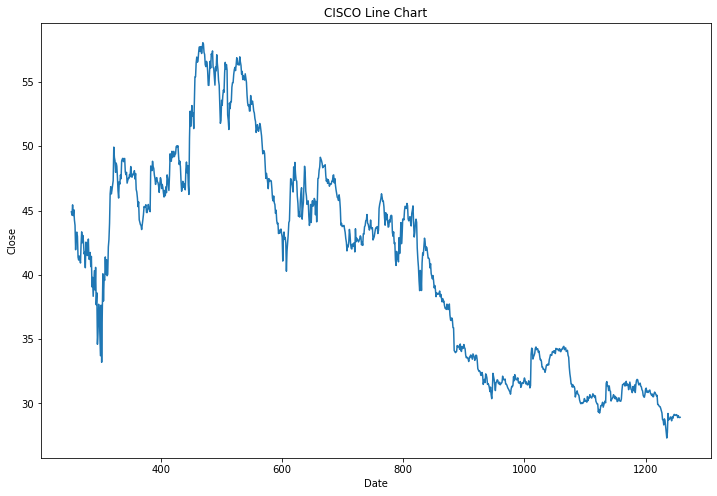

In [8]:
plt.figure(figsize=(12,8))
plt.plot(csco_df_4['Close/Last'])
plt.title("CISCO Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### PLOT SECOND DF (LAST YEAR)

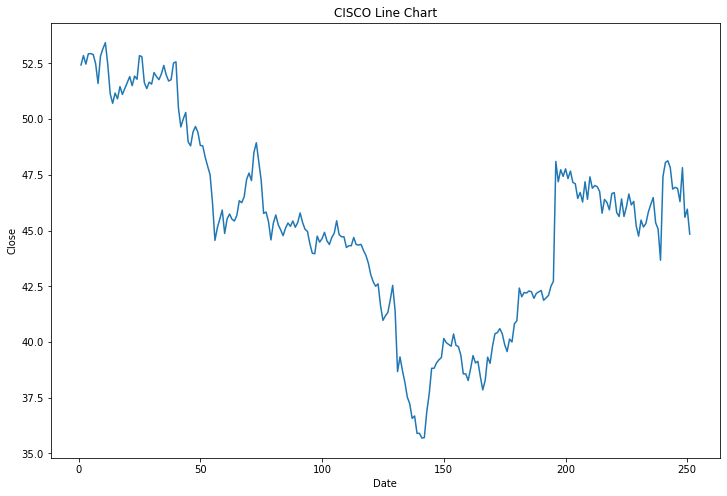

In [9]:
plt.figure(figsize=(12,8))
plt.plot(csco_df_ls['Close/Last'])
plt.title("CISCO Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### SHAPPING, FITTING, TRAINING, TESTING ML ON 1ST DF

In [10]:
csco_df_4.shape

(1006, 12)

In [11]:
X = np.array(csco_df_4['Open']).reshape(1006,-1)
Y = np.array(csco_df_4['Close/Last']).reshape(1006,-1)

In [12]:
lr = LinearRegression()

In [13]:
lr.fit(X, Y)

LinearRegression()

In [14]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [0.18821674]
coefficient count: 1


In [15]:
from sklearn.metrics import accuracy_score
print('Accuracy:', lr.score(X, Y))

Accuracy: 0.9959163112941815


In [16]:
# Predicting the price
lr.predict(X)

array([[44.65815329],
       [45.43465991],
       [45.03645139],
       ...,
       [29.00855843],
       [28.91896151],
       [28.64021555]])

In [17]:
#daily Return
DA_RE = csco_df_4['Close/Last'].pct_change(1)
DA_RE.head()

252         NaN
253   -0.005791
254    0.017921
255   -0.018376
256    0.010201
Name: Close/Last, dtype: float64

Text(0.5, 1.0, '4 Years CLosing Price vs Predicted Closing Price')

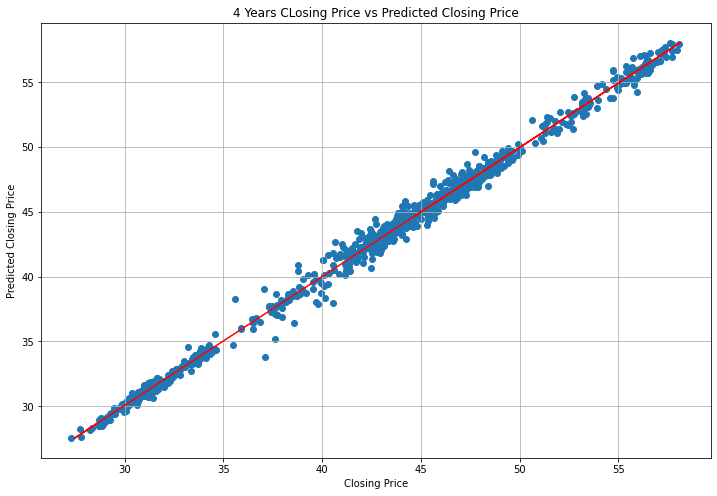

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(csco_df_4['Close/Last'], lr.predict(X))
plt.plot(X, lr.predict(X), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/csco_4y.jpg', dpi=40)
plt.grid()
plt.title('4 Years CLosing Price vs Predicted Closing Price')

### TRAINING, TESTING ML ON 2ND DF

In [19]:
csco_df_ls.shape

(251, 12)

In [20]:
X_ls = np.array(csco_df_ls['Open']).reshape(251,-1)
Y_ls = np.array(csco_df_ls['Close/Last']).reshape(251,-1)

In [21]:
lr.fit(X_ls, Y_ls)

LinearRegression()

In [22]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [-0.291846]
coefficient count: 1


In [23]:
print('Accuracy:', lr.score(X_ls, Y_ls))

Accuracy: 0.9828976853820317


In [24]:
# Predicting the price
lr.predict(X_ls)

array([[52.88161495],
       [50.50838458],
       [51.98976404],
       [52.91688589],
       [52.87657624],
       [53.04789223],
       [52.2215445 ],
       [52.29208638],
       [53.21920823],
       [54.09594301],
       [52.59440872],
       [51.17349373],
       [51.09287443],
       [51.21380337],
       [51.31457748],
       [51.3246549 ],
       [51.28434525],
       [51.66728688],
       [51.6874417 ],
       [51.75798358],
       [51.61034951],
       [51.91922216],
       [51.9494544 ],
       [52.70526025],
       [52.63975708],
       [52.56417649],
       [51.86883511],
       [51.61689982],
       [51.74790617],
       [52.18123486],
       [51.93937699],
       [52.05022851],
       [52.12077039],
       [52.09053816],
       [51.73581328],
       [51.8587577 ],
       [51.93937699],
       [52.2215445 ],
       [52.51459563],
       [50.69985539],
       [50.67466186],
       [50.03474624],
       [50.11536553],
       [49.02700511],
       [48.79522465],
       [48

Text(0.5, 1.0, '1 Year CLosing Price vs Predicted Closing Price')

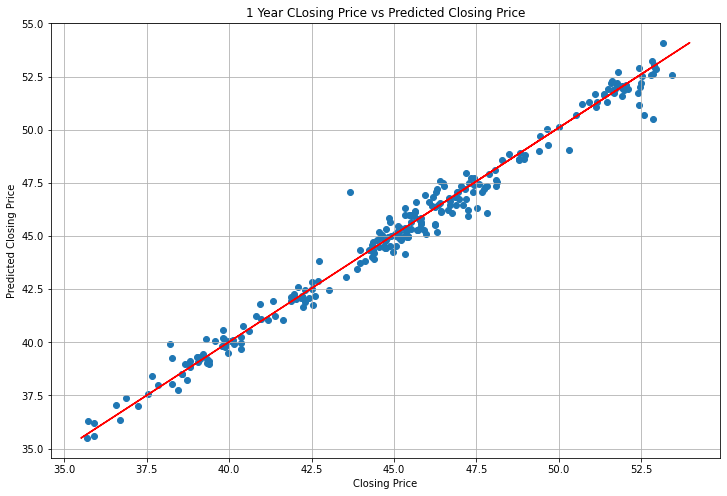

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(csco_df_ls['Close/Last'], lr.predict(X_ls))
plt.plot(X_ls, lr.predict(X_ls), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/csco_ls.jpg', dpi=40)
plt.grid()
plt.title('1 Year CLosing Price vs Predicted Closing Price')

### MODEL COMPARISON

<tr>
    <td> <img src="images/csco_4y.jpg"style="width: 550px;"/> </td>
    <td> <img src="images/csco_ls.jpg"style="width: 550px;"/> </td>
</tr>


In [26]:
csco_df.shape

(1257, 12)

In [27]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')

In [28]:
Xc = np.array(csco_df['Returns'], dtype = float) # Feature
Yc = np.array(csco_df['Close/Last'], dtype = float) # Target

In [29]:
model.fit(Xc, Yc, epochs=100)

Epoch 1/100
40/40 [==============================] - 0s 846us/step - loss: 950.8365
Epoch 2/100
40/40 [==============================] - 0s 846us/step - loss: 236.8196
Epoch 3/100
40/40 [==============================] - 0s 923us/step - loss: 95.9066
Epoch 4/100
40/40 [==============================] - 0s 872us/step - loss: 68.1330
Epoch 5/100
40/40 [==============================] - 0s 949us/step - loss: 62.4954
Epoch 6/100
40/40 [==============================] - 0s 846us/step - loss: 61.3757
Epoch 7/100
40/40 [==============================] - 0s 821us/step - loss: 61.2010
Epoch 8/100
40/40 [==============================] - 0s 872us/step - loss: 61.1700
Epoch 9/100
40/40 [==============================] - 0s 897us/step - loss: 61.1666
Epoch 10/100
40/40 [==============================] - 0s 846us/step - loss: 61.1594
Epoch 11/100
40/40 [==============================] - 0s 1ms/step - loss: 61.1711
Epoch 12/100
40/40 [==============================] - 0s 897us/step - loss: 61.1784
E

40/40 [==============================] - 0s 846us/step - loss: 61.1596
Epoch 99/100
40/40 [==============================] - 0s 744us/step - loss: 61.1631
Epoch 100/100
40/40 [==============================] - 0s 872us/step - loss: 61.1637


In [30]:
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(np.array(csco_df['Returns']).reshape(1257,-1))
X = np.array(normalized_X, dtype = float)
normalized_Y = scaler.fit_transform(np.array(csco_df['Close/Last']).reshape(1257,-1))
Y = np.array(normalized_Y, dtype = float)

In [31]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [32]:
print((model.predict([0])))

[[41.75862]]
